In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
path.ls()

(#3) [Path('C:/Users/jpadilla/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/jpadilla/.fastai/data/mnist_sample/train'),Path('C:/Users/jpadilla/.fastai/data/mnist_sample/valid')]

In [4]:
(path/'train').ls()

(#2) [Path('C:/Users/jpadilla/.fastai/data/mnist_sample/train/3'),Path('C:/Users/jpadilla/.fastai/data/mnist_sample/train/7')]

## 3 & 7 classifier

Want to build a model form scratach that recognizes the difference between 3's and 7's

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
img7_path = sevens[1]
img7 = Image.open(img7_path)
img7

In [5]:
# Load the images into tensors

tens_img7 = tensor(img7)

# Can visualize it a little better

df = pd.DataFrame(tens_img7)

In [9]:
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [6]:
# Establishing a baseline: Take the average pixel values of each number. 

# Grab all images
all_threes = [tensor(Image.open(three)) for three in threes]
all_seven = [tensor(Image.open(seven)) for seven in sevens]

In [7]:
# stack the tensors
stacked_threes = torch.stack(all_threes).float()/255 # unsure why we divided here: Want all values closer to 1
stacked_seven = torch.stack(all_seven).float()/255

In [9]:
def rmse(comp, ground):
    return ((comp - ground)**2).mean().sqrt()
def abse(comp, ground):
    return (comp - ground).abs().mean((-1,-2))


mean3 = stacked_threes.mean(0)
mean7 = stacked_seven.mean(0)
mean7.shape

torch.Size([28, 28])

In [11]:
test_3 = stacked_threes[1]
test_7 = stacked_seven[1]
test_7.shape

torch.Size([28, 28])

In [9]:
rmse_dist_3 = rmse(mean3,test_3 )
abs_dist_3 = abse(mean3,test_3)

rmse_dist_7 = rmse(mean7,test_3 )
abs_dist_7 = abse(mean7,test_3)


print(f"Threes: \n rmse: {rmse_dist_3:.3f} \n abs: {abs_dist_3:.3f} \n \n Sevens: \n rmse: {rmse_dist_7:.3f} \n abs: {abs_dist_7:.3f} ")

Threes: 
 rmse: 0.202 
 abs: 0.111 
 
 Sevens: 
 rmse: 0.302 
 abs: 0.159 


In [84]:
# The 3's are futher away form the 7's so the baseline will work to differentiate 3's and 7's

In [10]:
# Grab the Validation set 

valid_7 = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()])
valid_3 = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()])


valid_7 = valid_7.float()/255
valid_3 = valid_3.float()/255

In [11]:
valid_3_dist = abse(valid_3, mean3)
valid_7_dist = abse(valid_7, mean7)

In [12]:
valid_3.shape

torch.Size([1010, 28, 28])

In [22]:
def is_3(x):
    return abse(x, mean3) < abse(x, mean7)

In [29]:
outcomes3 = is_3(valid_3)
outcomes7 = is_3(valid_7)

In [36]:
accuracy3 = outcomes3.float().mean()
accuracy7 = (1- outcomes7.float().mean())

In [38]:
(accuracy3+accuracy7)/2

tensor(0.9511)

In [69]:
## Implement gradients

def para(x): return (x**2).sum()

xt = tensor([4.,6.,5.]).requires_grad_()
yt = para(xt)
yt.backward()

In [71]:
xt.grad

tensor([ 8., 12., 10.])

In [95]:
#  Actually creating the model  
# 1's for threes and 0's for sevens
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

train_x = torch.cat([stacked_threes, stacked_seven]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_dataset = list(zip(train_x, train_y))

valid_x = torch.cat([valid_3, valid_7]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3)+[0]*len(valid_7)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

In [98]:
# Init the weights, Need a weight for every pixel
weights = init_params((28*28,1))
weights.shape

torch.Size([784, 1])

In [99]:
# intit the bias y= m*x +b -> NN's use: w*x + b
# Bias is the same for every neuron

bias = init_params(1)
bias

tensor([0.3215], requires_grad=True)

In [117]:
# @ performs matrix multiplication. If we did not use it here we could do train_x[0]* weights.T
pred = train_x[0]@weights +bias
pred

tensor([7.3167], grad_fn=<AddBackward0>)

In [118]:
# Implementing linear1: Mat mul baby

def linear1(x, weights):
    return x @ weights + bias

first_pass = linear1(train_x, weights)
first_pass.shape

torch.Size([12396, 1])

In [127]:
corrects = (first_pass>0.0).float() == train_y
corrects.float().mean().item()

0.5596160292625427

In [129]:
# Let's see what happens when we nudge on of the weights
with torch.no_grad():
    weights[0] *= 1.0001
nudge_pass = linear1(train_x, weights)
corrects = (nudge_pass>0.0).float() == train_y
corrects.float().mean().item()

0.5596160292625427

In [15]:
targets = tensor([1,0,1])
prds = tensor([0.9,0.4,0.8])

torch.where(targets==1, 1-prds, prds).mean()

tensor(0.2333)

In [14]:
def mnist_loss(trgt, prds):
    prds = prds.sigmoid()
    return torch.where(trgt==1, 1-prds, prds).mean()

mnist_loss(targets, prds)

tensor(0.4333)

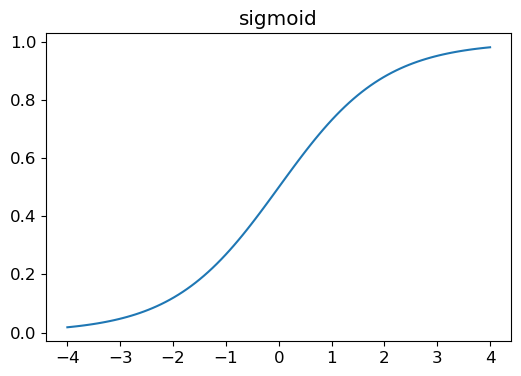

In [25]:
plot_function(torch.sigmoid, title= "sigmoid", min =-4, max=4)

In [26]:
# Dataloader exploration

coll = range(15)

dls = DataLoader(coll, batch_size=5, shuffle=True)

In [29]:
list(dls)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [31]:
# what about a labeled dataset?

l_n = L(enumerate(string.ascii_lowercase))
dl = DataLoader(l_n, batch_size=4, shuffle = True)

In [33]:
list(dl)

[(tensor([17, 18, 10, 22]), ('r', 's', 'k', 'w')),
 (tensor([ 8, 14, 20, 15]), ('i', 'o', 'u', 'p')),
 (tensor([ 9, 13, 21, 12]), ('j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5]), ('h', 'z', 'g', 'f')),
 (tensor([11, 23,  1,  3]), ('l', 'x', 'b', 'd')),
 (tensor([ 0, 24, 19, 16]), ('a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]